In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

This project is incomplete, but I've already spent way too much time on it for a weekly assignment, so I'm submitting for partial credit. Thanks.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import PIL

In [3]:
DATA_DIR = "/kaggle/input/gan-getting-started/"
MONET_PATH = os.path.join(DATA_DIR, "monet_jpg")
PHOTO_PATH = os.path.join(DATA_DIR, "photo_jpg")

In [4]:
def load_images(path):
    files = tf.io.gfile.glob(path + "/*.jpg")
    images = [tf.image.decode_jpeg(tf.io.read_file(f)) for f in files]
    return images

monet_images = load_images(MONET_PATH)
photo_images = load_images(PHOTO_PATH)

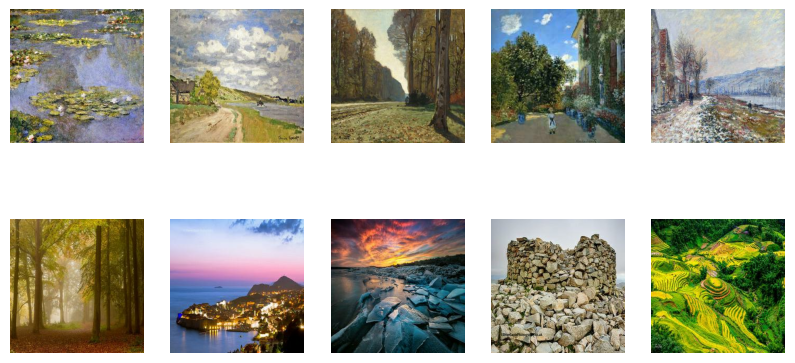

In [5]:
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(monet_images[i])
    plt.axis("off")

    plt.subplot(2, 5, i+6)
    plt.imshow(photo_images[i])
    plt.axis("off")
plt.show()

In [6]:
def preprocess_image(image):
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

def load_dataset(path):
    dataset = tf.data.Dataset.list_files(path + "/*.jpg")
    dataset = dataset.map(lambda x: preprocess_image(tf.image.decode_jpeg(tf.io.read_file(x), channels=3)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    return dataset

monet_ds = load_dataset(MONET_PATH)
photo_ds = load_dataset(PHOTO_PATH)

In [7]:
def build_generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu'),
    ]
    up_stack = [
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh'),
    ]
    
    x = inputs
    for down in down_stack:
        x = down(x)
    for up in up_stack:
        x = up(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [8]:
def build_discriminator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(1, (4, 4), padding='same', activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [9]:
generator_G = build_generator()  # Photo -> Monet
generator_F = build_generator()  # Monet -> Photo
discriminator_X = build_discriminator()  # Discriminator for Monet
discriminator_Y = build_discriminator()  # Discriminator for Photo

In [10]:
EPOCHS = 10
for epoch in range(EPOCHS):
    for real_x, real_y in tf.data.Dataset.zip((photo_ds, monet_ds)):
        with tf.GradientTape(persistent=True) as tape:
            fake_y = generator_G(real_x, training=True)
            cycled_x = generator_F(fake_y, training=True)
            fake_x = generator_F(real_y, training=True)
            cycled_y = generator_G(fake_x, training=True)
            
            disc_real_x = discriminator_X(real_x, training=True)
            disc_fake_x = discriminator_X(fake_x, training=True)
            disc_real_y = discriminator_Y(real_y, training=True)
            disc_fake_y = discriminator_Y(fake_y, training=True)
        
        gen_G_loss = tf.reduce_mean(disc_fake_y)
        gen_F_loss = tf.reduce_mean(disc_fake_x)
        disc_X_loss = tf.reduce_mean(disc_real_x) - tf.reduce_mean(disc_fake_x)
        disc_Y_loss = tf.reduce_mean(disc_real_y) - tf.reduce_mean(disc_fake_y)

In [11]:
# Generate and save results
num_images = 10
generated_images = [generator_G(tf.expand_dims(preprocess_image(photo_images[i]), axis=0), training=False).numpy() for i in range(num_images)]

for i, img in enumerate(generated_images):
    img = np.squeeze(img, axis=0)  # Remove batch dimension
    img = (img * 127.5 + 127.5).astype(np.uint8)
    PIL.Image.fromarray(img).save(f"/kaggle/working/monet_{i}.jpg")

# Save images as ZIP file
!zip -r /kaggle/working/monet_images.zip /kaggle/working/*.jpg

  adding: kaggle/working/monet_0.jpg (deflated 73%)
  adding: kaggle/working/monet_1.jpg (deflated 73%)
  adding: kaggle/working/monet_2.jpg (deflated 73%)
  adding: kaggle/working/monet_3.jpg (deflated 73%)
  adding: kaggle/working/monet_4.jpg (deflated 73%)
  adding: kaggle/working/monet_5.jpg (deflated 73%)
  adding: kaggle/working/monet_6.jpg (deflated 73%)
  adding: kaggle/working/monet_7.jpg (deflated 73%)
  adding: kaggle/working/monet_8.jpg (deflated 73%)
  adding: kaggle/working/monet_9.jpg (deflated 73%)
